In [43]:
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from astropy import constants as astroconts
from scipy import stats
import time

# Supernova data
from astroML.datasets import generate_mu_z

# Machine learning
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# dynesty
import dynesty
from dynesty import plotting as dyplot # dynesty plots

In [44]:
# Random generate some supernova data
N = 100
z_sample, mu_sample, dmu = generate_mu_z(size=N, random_state=20240513)

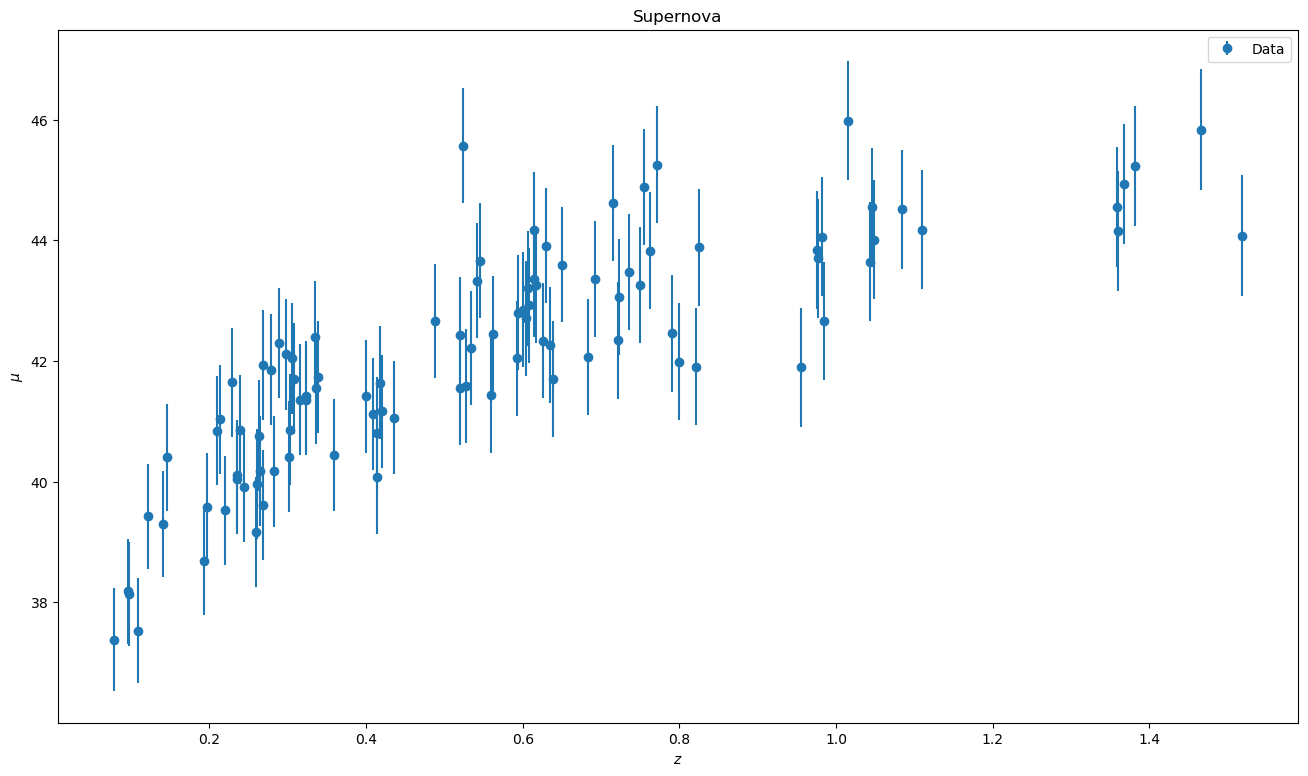

In [45]:
# Plot the data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Supernova')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')

ax.errorbar(z_sample, mu_sample, yerr=dmu, linestyle='', marker='o', label='Data')

ax.legend()

plt.show()

# Try a GPR

In [46]:
# Initialise a kernel a radial-basis function
# the kernels from scikit-learn automatically optimizes the lenght_scale parameter
kernel = kernels.RBF(length_scale=0.01)

# I set the noise parameter (alpha) to the errors of the data (i.e. the variance)
# This is added to the diagonal of the kernel matrix during fitting
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, normalize_y=True, n_restarts_optimizer=100)

# Fit to the data
gpr.fit(z_sample[:, np.newaxis], mu_sample)

GaussianProcessRegressor(alpha=array([0.84457374, 0.9757769 , 0.83866412, 0.91582533, 0.86115076,
       0.81190245, 0.83150664, 0.95983213, 0.93499774, 0.99941479,
       0.83716247, 0.81316774, 0.78081491, 0.89781719, 0.93235046,
       0.90108451, 0.9697694 , 0.96227193, 0.85099461, 0.83381158,
       1.00966422, 0.87465485, 0.83382847, 0.81951041, 0.93988597,
       0.87132776, 0.85542248, 0.91788573, 0.8970...
       0.90442319, 0.87963529, 0.89844382, 0.90191885, 0.8747323 ,
       0.87341428, 0.91627991, 0.96210525, 0.85120759, 0.82214038,
       0.9977698 , 0.91428715, 0.74705643, 0.93062051, 0.82188004,
       0.93434448, 0.84485942, 0.99765551, 0.93031342, 0.99831575,
       0.84334493, 0.9138933 , 0.92950373, 0.89976087, 0.84567142,
       0.81603876, 0.94103196, 0.9629905 , 0.80646   , 0.76552837]),
                         kernel=RBF(length_scale=0.01),
                         n_restarts_optimizer=100, normalize_y=True)

In [47]:
# Define a z grid for the model
n_grid_points = 1000

z_grid = np.linspace(0, 1.5 * np.max(z_sample), n_grid_points)

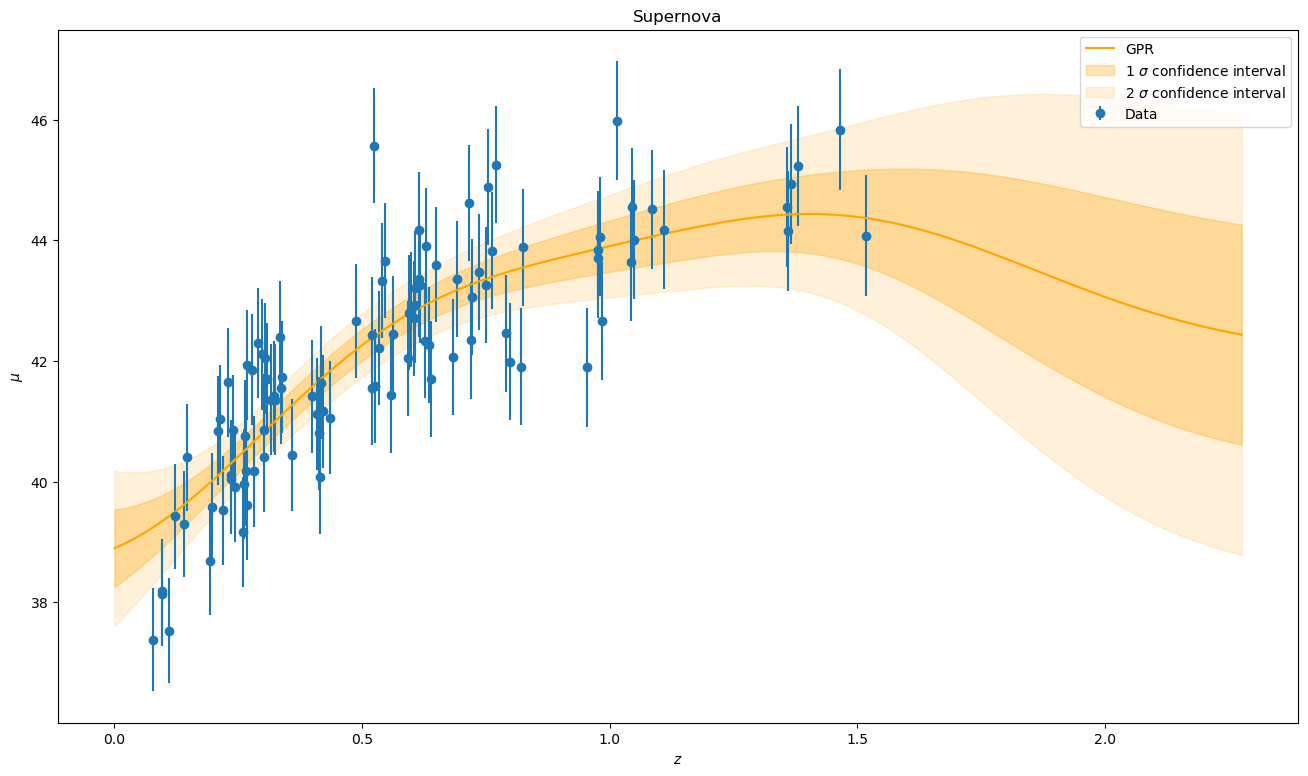

In [48]:
# Plot the data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Supernova')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')

# Data
ax.errorbar(z_sample, mu_sample, yerr=dmu, linestyle='', marker='o', label='Data')

# GPR with contours levels
gpr_fit, gpr_fit_err = gpr.predict(z_grid[:, np.newaxis], return_std=True)
ax.plot(z_grid, gpr_fit, label='GPR', color='orange')

# Contours
sigma_levels = [1, 2]
sigma_alphas = [0.3 / sl for sl in sigma_levels] # Transparencies list for contours
for sl, i in zip(sigma_levels, range(len(sigma_levels))):
    ax.fill_between(z_grid, gpr_fit + sl * gpr_fit_err, gpr_fit - sl * gpr_fit_err,
                    alpha=sigma_alphas[i], color='orange',
                    label=r'${0}\ \sigma$ confidence interval'.format(sl))

ax.legend()

plt.show()

# Model selection

## Making the model

This consists in a _flat universe_ ($\Omega_m + \Omega_\Lambda = 1$) characterized by _2 parameters_: the Hubble constant $H_0$ and the matter content of the universe $\Omega_m$. We have:

\begin{align*}
\mu(z) = 5 \log \left(\frac{c / H_0}{10 \text{pc}} (1+z) \int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z'^3) + \Omega_\Lambda}} \right)
\end{align*}

See **L03** for informations to compute the integral.

In [49]:
# Speed of light
c = astroconts.c.value / 1000 # km / s

# Support function for the model
# MC_size is the size of the samples for the Montecarlo integration
def support_mu_integral(z, Omega_m, MC_size=100000):
    # Get the value of the uniform PDF
    uniform_pdf = z # z - 0

    # Generate numbers from the uniform distribution
    uniform_samples = np.random.uniform(0, z, MC_size)

    # Evaluate the integrand at the sampled points
    # Use the fact that Omega_Lambda = 1 - Omega_m
    integrand = 1 / np.sqrt(Omega_m * (1 + uniform_samples ** 3) + (1 - Omega_m))

    # Compute the integral as the mean of the computed integrands times the uniform PDF
    integral = uniform_pdf * np.mean(integrand)

    return integral

# Define the model
# c [km / s]
# H_0 [km / s / Mpc]
# 1e-5 [Mpc]
def mu(z, H_0, Omega_m, MC_size=100000):
    integral = support_mu_integral(z, Omega_m, MC_size)
    return 5 * np.log10((c / H_0 / 1e-5) * (1 + z) * integral)

## dynesty implementation (nested sampling)

In [50]:
par_keys = ['H_0', 'Omega_m']
par_labels = [r'$H_0$', r'$\Omega_m$']
par_indexes = dict(zip(par_keys, range(len(par_keys))))

quantiles = [0.05, 0.5, 0.95]

In [51]:
# Number of dimension of the problem
ndim = 2

# Define our uniform prior via the prior transform.
# u is the unit hypercube from which parameters are initially sampled
def ptform(u, Omega_m=None):
    theta = np.array(u)

    H_0_loc, H_0_scale = 60, 30 # km / s / Mpc
    theta[par_indexes['H_0']] = stats.uniform.ppf(u[par_indexes['H_0']], H_0_loc, H_0_scale)
    theta[par_indexes['Omega_m']] = stats.uniform.ppf(u[par_indexes['Omega_m']], 0, 1)

    # If Omega_m is given, then fix its parameter to the given value
    if Omega_m != None:
        theta[par_indexes['Omega_m']] = Omega_m

    return theta

# The loglikelihood of the data given the (sampled) model
# theta is an array of the parameters of the model as transformed by ptform()
def loglike(theta, MC_size=10000):
    H_0 = theta[par_indexes['H_0']]
    Omega_m = theta[par_indexes['Omega_m']]

    # Compute the expected mu with the model given by theta at every redshift
    expected_mu = np.array([mu(z, H_0, Omega_m, MC_size) for z in z_sample])

    # Compute the loglikelihood of the data assuming a normal distribution around the model
    # I'm not normalizing because I'm going to compare models using odds ratios
    logL = 0
    for i in range(N):
        logL += np.log(stats.norm.pdf(mu_sample[i], expected_mu[i], dmu[i]))
    
    return logL

### Unconstrained $\Omega_m$

In [52]:
# Initialize the sampler
ptform_arg = dict(Omega_m = None)
loglike_arg = dict(MC_size = 10000) # High values higly impact the computation time

sampler_MLambda = dynesty.NestedSampler(loglike, ptform, ndim, logl_kwargs=loglike_arg, ptform_kwargs=ptform_arg)

In [53]:
# Sample the model using nested sampling
sampler_MLambda.run_nested()

1407it [06:42,  3.50it/s, +500 | bound: 0 | nc: 1 | ncall: 9261 | eff(%): 21.767 | loglstar:   -inf < -132.057 <    inf | logz: -134.063 +/-  0.045 | dlogz:  0.001 >  0.509]


In [54]:
sresults_MLambda = sampler_MLambda.results

sresults_MLambda

         nlive: 500
         niter: 1407
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 21.766921584294032
       samples: array([[6.01974918e+01, 3.23177416e-02],
       [6.03377946e+01, 2.29032309e-02],
       [6.04564961e+01, 7.64797911e-02],
       ...,
       [7.78554903e+01, 9.92139516e-01],
       [7.81314780e+01, 9.95326435e-01],
       [7.74159786e+01, 9.86341334e-01]])
          blob: array([None, None, None, ..., None, None, None], dtype=object)
    samples_id: array([353, 245, 200, ..., 251, 320,  64])
    samples_it: array([   0,    0,    0, ..., 1056, 1390,  609])
     samples_u: array([[0.00658306, 0.03231774],
       [0.01125982, 0.02290323],
       [0.01521654, 0.07647979],
       ...,
       [0.59518301, 0.99213952],
       [0.6043826 , 0.99532644],
       [0.58053262, 0.98634133]])
         logwt: array([-163.32244388, -162.50113062, -161.84337666, ..., -141.09146946,
       -141.08571554, -141.08447631])
          logl: array([-156.4126906 , -156.167

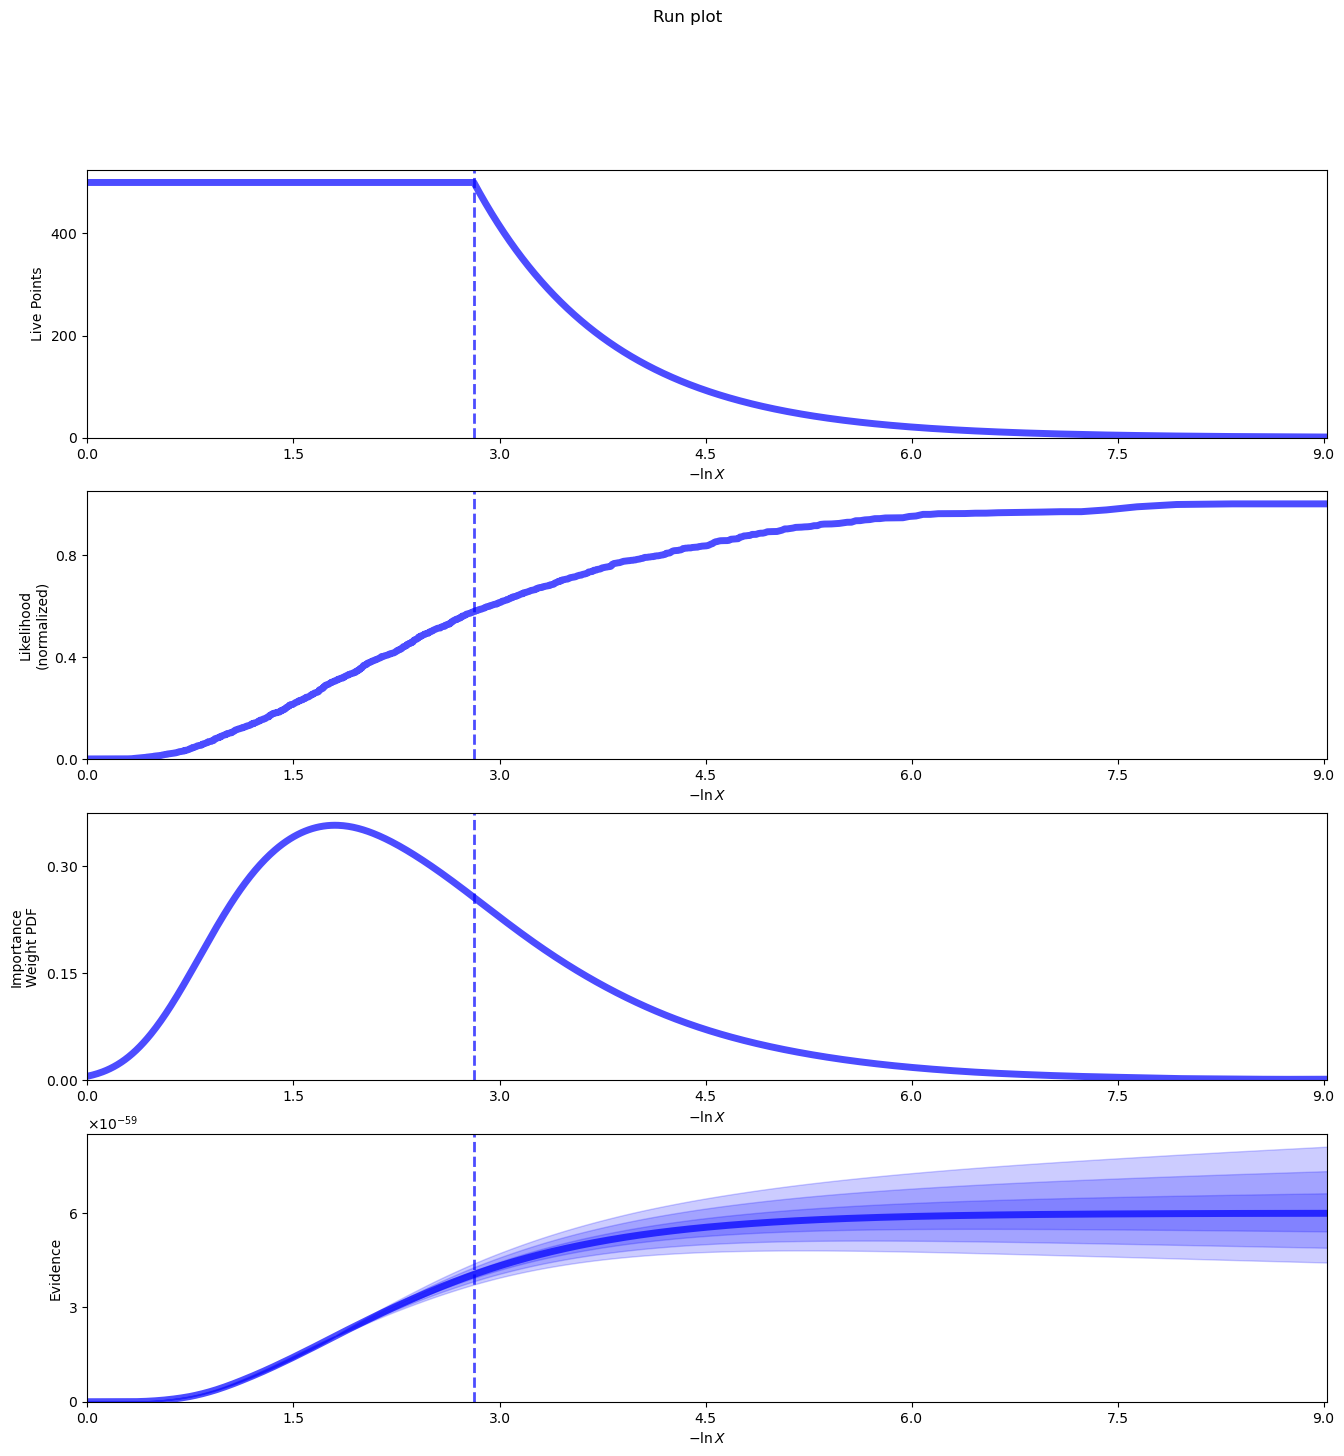

In [55]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults_MLambda)

rfig.suptitle("Run plot")

plt.show()

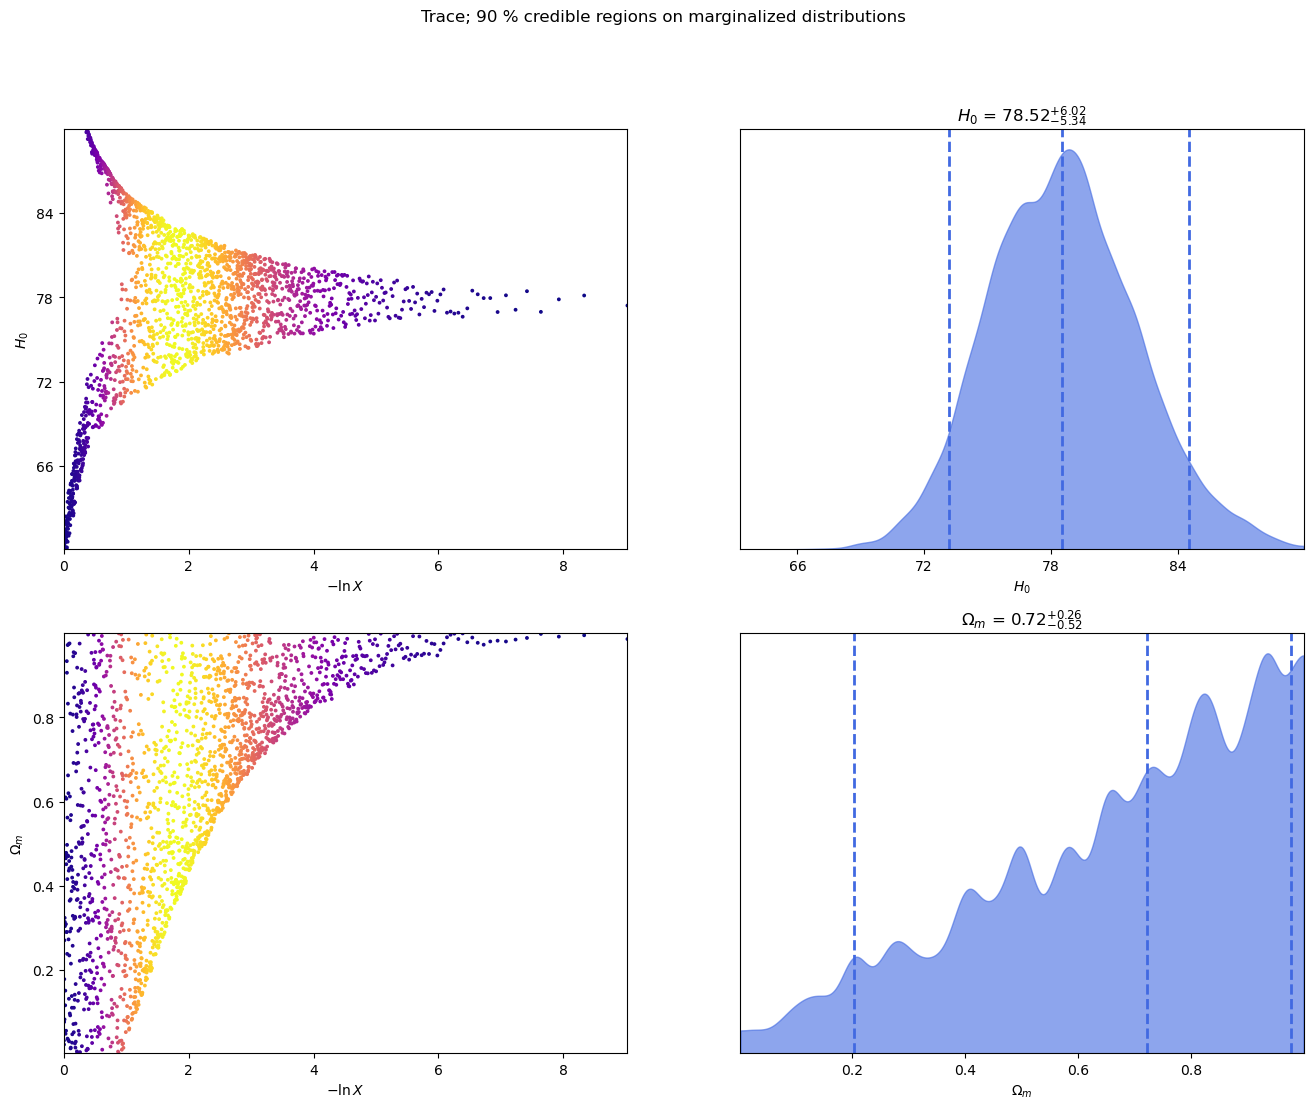

In [56]:
# Trace plot
tfig, taxes = dyplot.traceplot(sresults_MLambda,
                               labels=par_labels,
                               show_titles=True,
                               quantiles=quantiles,
                               title_quantiles=quantiles,
                               post_color='royalblue')

tfig.set_size_inches(16, 12)
tfig.suptitle("Trace; "
              "90 % credible regions on marginalized distributions")

plt.show()

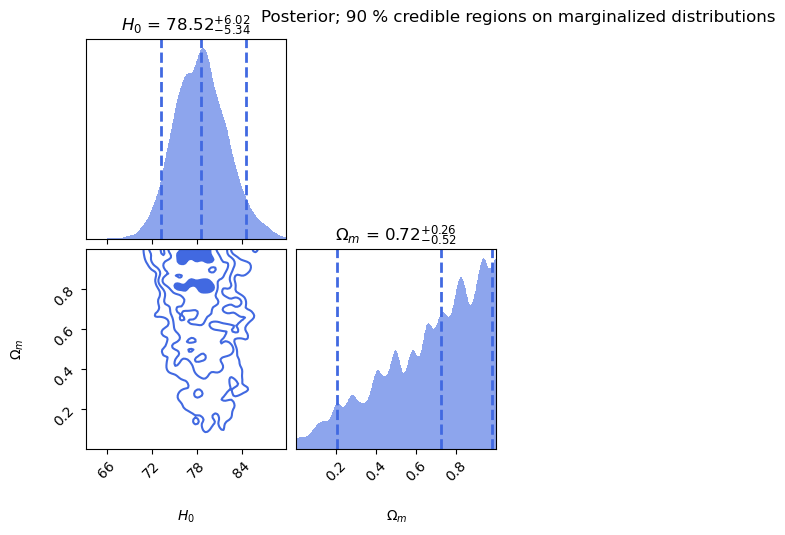

In [57]:
# Corner plot
cfig, caxes = dyplot.cornerplot(sresults_MLambda,
                                labels=par_labels,
                                show_titles=True,
                                color='royalblue',
                                quantiles=quantiles,
                                title_quantiles=quantiles)

cfig.suptitle("Posterior; "
              "90 % credible regions on marginalized distributions", horizontalalignment='left')

plt.show()

### $\Omega_m = 1$ (no dark energy)

In [58]:
# Initialize a new sampler for the model with Omega_m = 1
ptform_arg = dict(Omega_m = 1)
loglike_arg = dict(MC_size = 10000) # High values higly impact the computation time

sampler_M = dynesty.NestedSampler(loglike, ptform, ndim, logl_kwargs=loglike_arg, ptform_kwargs=ptform_arg)

In [59]:
sampler_M.run_nested()

1069it [03:33,  5.00it/s, +500 | bound: 0 | nc: 1 | ncall: 5412 | eff(%): 31.942 | loglstar:   -inf < -132.014 <    inf | logz: -133.261 +/-    nan | dlogz:  0.001 >  0.509]


In [60]:
sresults_M = sampler_M.results

sresults_M

         nlive: 500
         niter: 1069
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 31.942182410423452
       samples: array([[60.03913126,  1.        ],
       [60.13090159,  1.        ],
       [60.31859214,  1.        ],
       ...,
       [77.55986634,  1.        ],
       [77.9149647 ,  1.        ],
       [77.89901422,  1.        ]])
          blob: array([None, None, None, ..., None, None, None], dtype=object)
    samples_id: array([ 92, 337, 222, ..., 196, 154,  31])
    samples_it: array([  0,   0,   0, ..., 874,   0, 637])
     samples_u: array([[0.00130438, 0.61147553],
       [0.00436339, 0.87538549],
       [0.01061974, 0.23230761],
       ...,
       [0.58532888, 0.7482201 ],
       [0.59716549, 0.54370422],
       [0.59663381, 0.26835817]])
         logwt: array([-156.71425099, -155.8886603 , -155.55455017, ..., -140.37841801,
       -140.37756745, -140.37160639])
          logl: array([-149.8044977 , -149.55156586, -149.15532738, ..., -132.02571169,


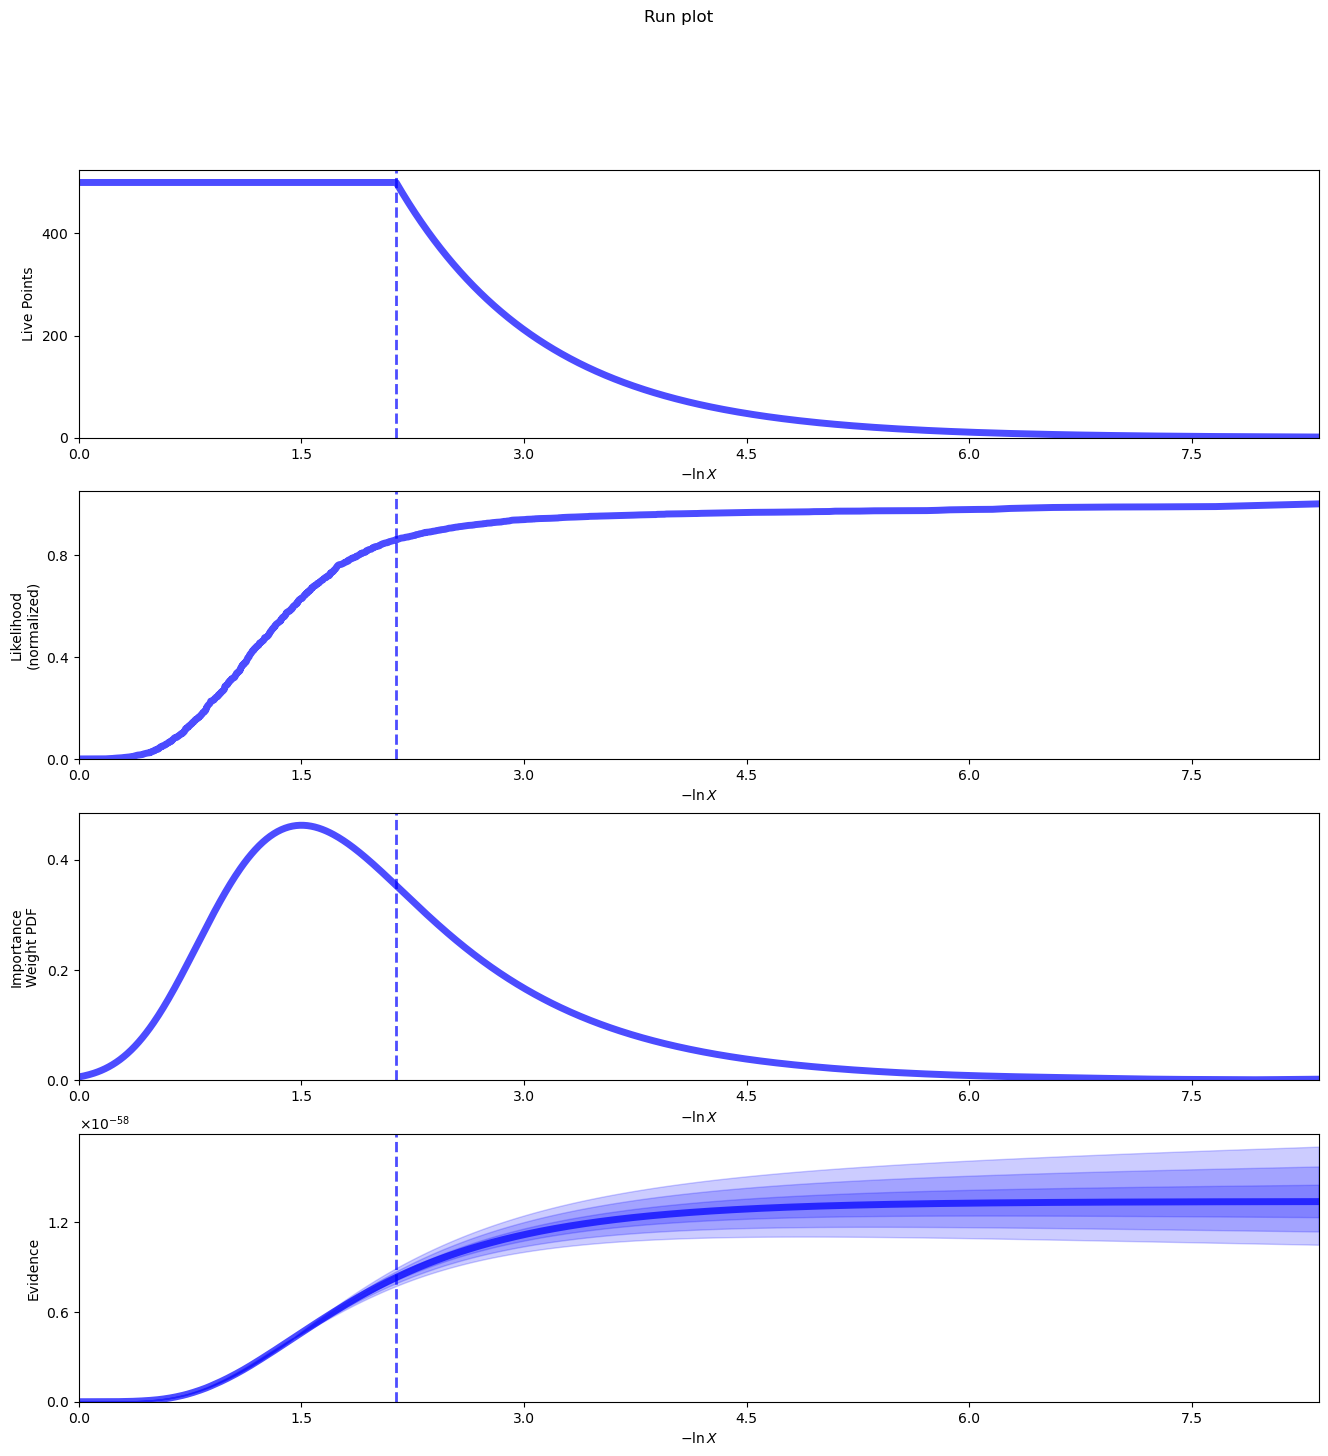

In [61]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults_M)

rfig.suptitle("Run plot")

plt.show()

/Users/Federico/Library/Python/3.12/lib/python/site-packages/dynesty/plotting.py:706: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min(x), max(x)])
/Users/Federico/Library/Python/3.12/lib/python/site-packages/dynesty/plotting.py:749: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])


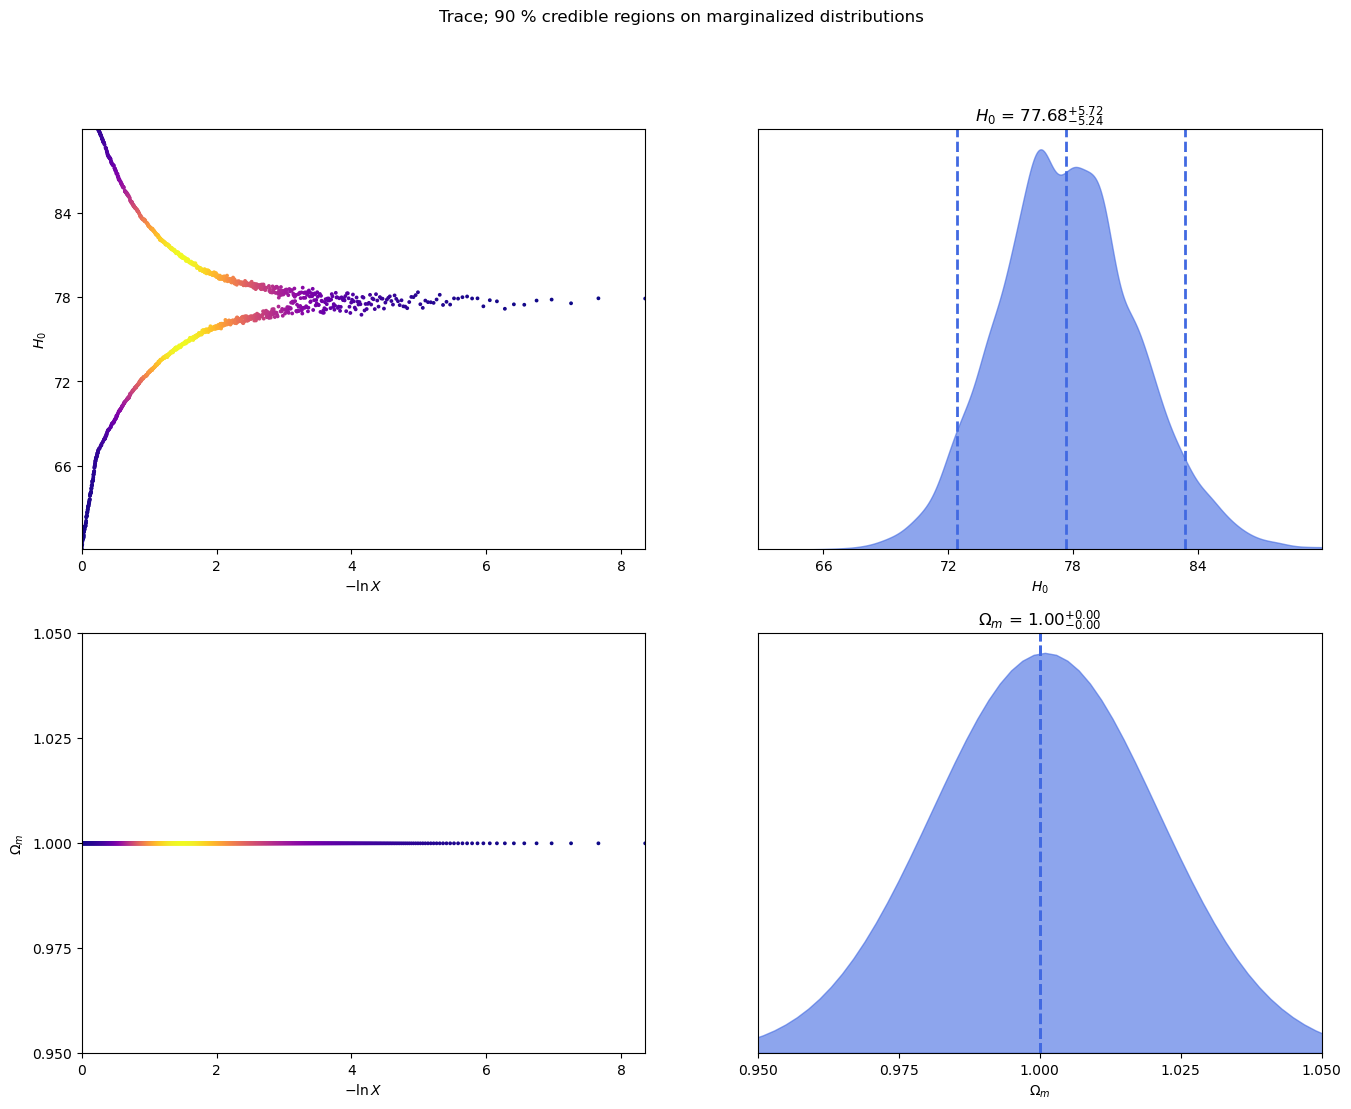

In [62]:
# Trace plot
tfig, taxes = dyplot.traceplot(sresults_M,
                               labels=par_labels,
                               show_titles=True,
                               quantiles=quantiles,
                               title_quantiles=quantiles,
                               post_color='royalblue')

tfig.set_size_inches(16, 12)
tfig.suptitle("Trace; "
              "90 % credible regions on marginalized distributions")

plt.show()

/Users/Federico/Library/Python/3.12/lib/python/site-packages/dynesty/plotting.py:1320: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])
/Users/Federico/Library/Python/3.12/lib/python/site-packages/dynesty/plotting.py:2393: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(span[1])


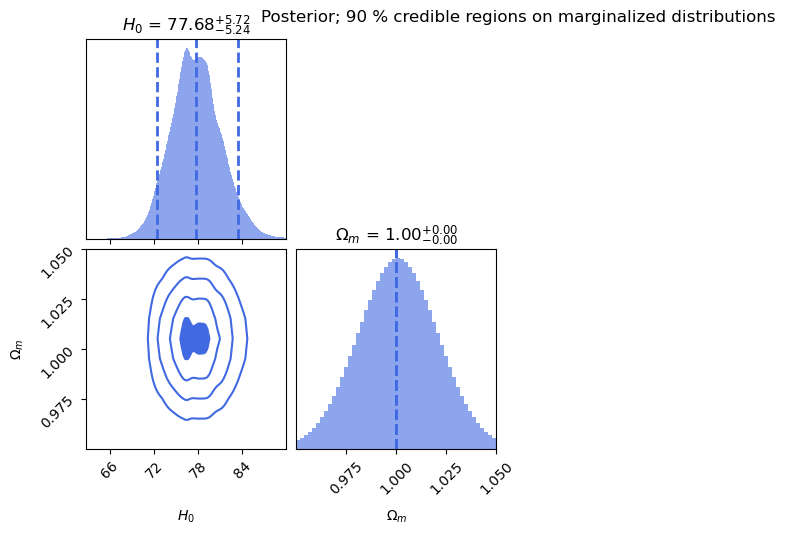

In [63]:
# Corner plot
cfig, caxes = dyplot.cornerplot(sresults_M,
                                labels=par_labels,
                                show_titles=True,
                                color='royalblue',
                                quantiles=quantiles,
                                title_quantiles=quantiles)

cfig.suptitle("Posterior; "
              "90 % credible regions on marginalized distributions", horizontalalignment='left')

plt.show()

In [64]:
# Compute the logarithm of the bayes factor using the evidences
log_Bayes_factor_M_vs_MLambda = sresults_M['logz'][-1] - sresults_MLambda['logz'][-1]

print("log(Bayes factor) = " + str(log_Bayes_factor_M_vs_MLambda))

log(Bayes factor) = 0.8020917918248074


There is **_Higher_** evidence in favor of the $\Omega_m = 1$ model rather than the $\Omega_m + \Omega_\Lambda = 1$ model

## Generate new data from the starting ones

### Distribution of $z$

In [65]:
# Search for the best bandwidth for the kernel for the sampled z
bw_grid = GridSearchCV(KernelDensity(), dict(bandwidth = np.linspace(0.01, 1, 1000)), cv=5)

bw_grid.fit(z_sample[:, np.newaxis])

GridSearchCV(cv=5, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.01      , 0.01099099, 0.01198198, 0.01297297, 0.01396396,
       0.01495495, 0.01594595, 0.01693694, 0.01792793, 0.01891892,
       0.01990991, 0.0209009 , 0.02189189, 0.02288288, 0.02387387,
       0.02486486, 0.02585586, 0.02684685, 0.02783784, 0.02882883,
       0.02981982, 0.03081081, 0.0318018 , 0.03279279, 0.03378378,
       0.034774...
       0.96630631, 0.9672973 , 0.96828829, 0.96927928, 0.97027027,
       0.97126126, 0.97225225, 0.97324324, 0.97423423, 0.97522523,
       0.97621622, 0.97720721, 0.9781982 , 0.97918919, 0.98018018,
       0.98117117, 0.98216216, 0.98315315, 0.98414414, 0.98513514,
       0.98612613, 0.98711712, 0.98810811, 0.9890991 , 0.99009009,
       0.99108108, 0.99207207, 0.99306306, 0.99405405, 0.99504505,
       0.99603604, 0.99702703, 0.99801802, 0.99900901, 1.        ])})

In [66]:
bw_grid.best_params_['bandwidth']

0.042702702702702704

In [67]:
# Initialize and fit KDEs with the optimized bandwidth and with a manually selected one
# Optimized
opt_z_kde = KernelDensity(bandwidth=bw_grid.best_params_['bandwidth'])

# Manually selected
my_bw = 0.17
my_z_kde = KernelDensity(bandwidth=my_bw)

# Fit both
my_z_kde.fit(z_sample[:, np.newaxis])
opt_z_kde.fit(z_sample[:, np.newaxis])

KernelDensity(bandwidth=0.042702702702702704)

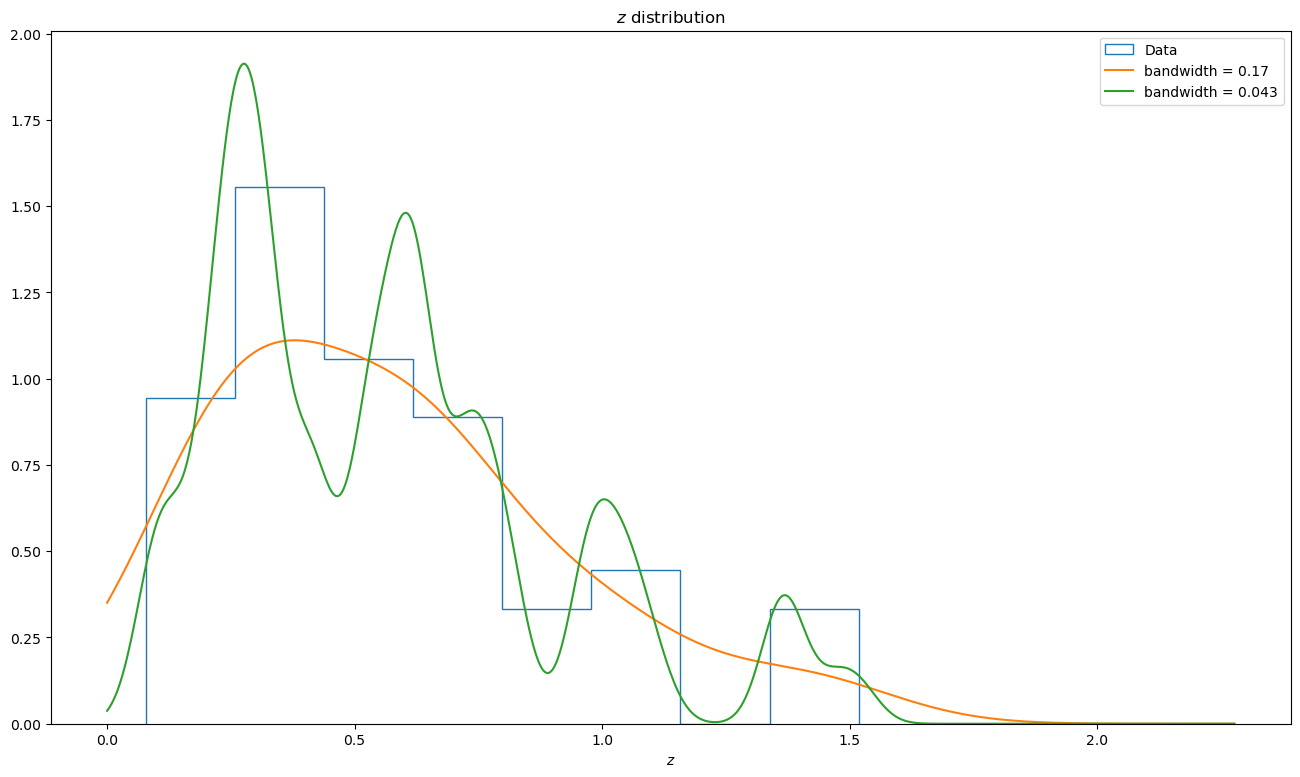

In [68]:
# Plot the z distribution with its KDEs
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title(r'$z$ distribution')
ax.set_xlabel(r'$z$')

# Data
ax.hist(z_sample, bins='auto', density=True, histtype='step', label='Data')

# KDEs
ax.plot(z_grid, np.exp(my_z_kde.score_samples(z_grid[:, np.newaxis])),
        label='bandwidth = {0}'.format(np.format_float_positional(my_bw, 3)))
ax.plot(z_grid, np.exp(opt_z_kde.score_samples(z_grid[:, np.newaxis])),
        label='bandwidth = {0}'.format(np.format_float_positional(bw_grid.best_params_['bandwidth'], 3)))

ax.legend()

plt.show()

I choose my bandwith to sample new values of $z$.

I sample from the KDE and I discard negative values.

In [69]:
# Sample new values of z to generate new data points
# Costrain the samples to be positive: iteratively generate the missing points
# until you have the desired number

sample_size = 0 # Number of sampled points
new_z_sample = my_z_kde.sample(N, random_state=int(time.time())) # First sampling

# sample() already provides the correct shape for the scikit-learn interface
# I keep the correct shape by using properly the 'axis' parameter in numpy functions
while sample_size < N:
    # Delete negative z
    new_z_sample = np.delete(new_z_sample, np.where(new_z_sample < 0)[0], axis=0)

    # Update the number of sampled points
    sample_size = len(new_z_sample)

    # Generate the missing number of points
    new_z_sample = np.append(new_z_sample, my_z_kde.sample(N - sample_size, random_state=int(time.time())),
                             axis=0)

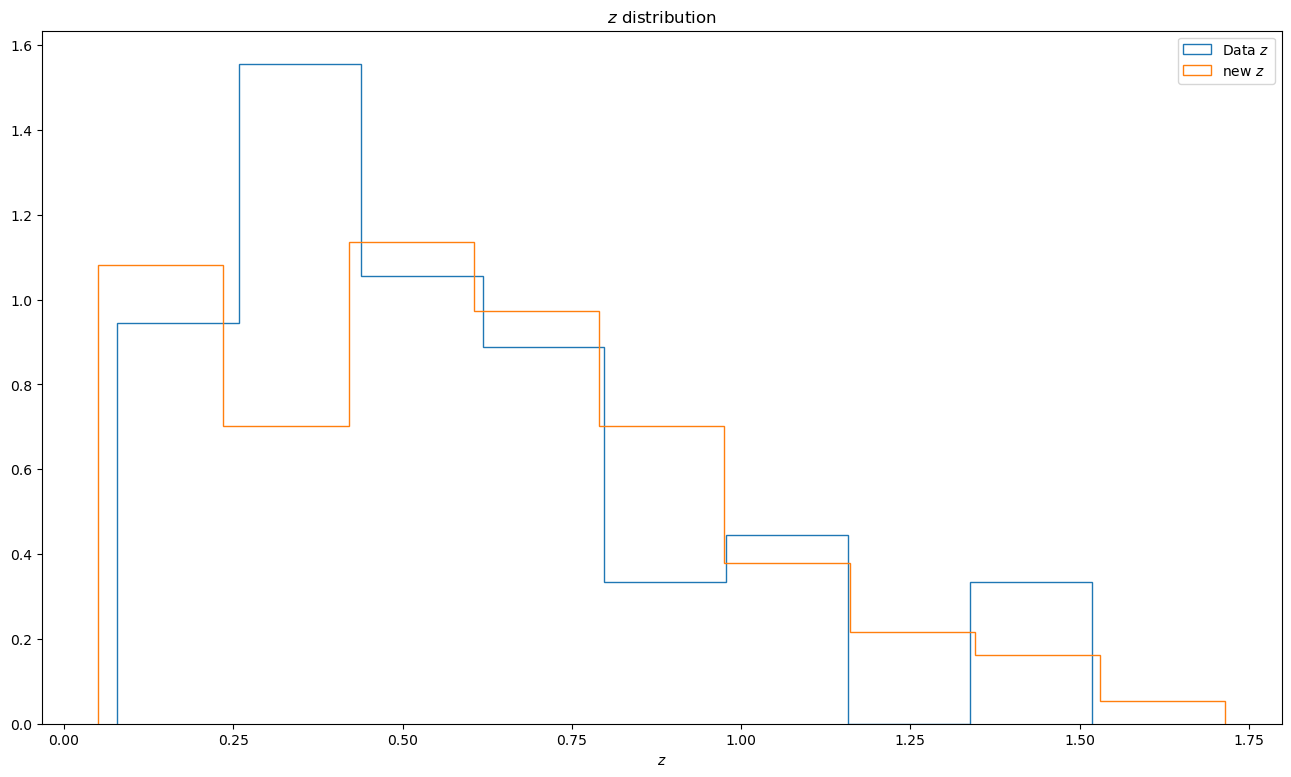

In [70]:
# Plot the new z distribution along with the original data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title(r'$z$ distribution')
ax.set_xlabel(r'$z$')

ax.hist(z_sample, bins='auto', density=True, histtype='step', label='Data $z$')
ax.hist(new_z_sample, bins='auto', density=True, histtype='step', label='new $z$')

ax.legend()

plt.show()

### Generate new $\mu$ from the sampled $z$.

#### GPR

In [71]:
# Generate some mu for every new sampled z
n_mu_samples = 100
new_mu_sample_gpr = gpr.sample_y(new_z_sample, n_samples=n_mu_samples, random_state=int(time.time()))

In [72]:
# For every z select 1 random mu and
# Compute the standard deviation of the sampled mu
temp_new_mu = np.zeros(len(new_mu_sample_gpr))
new_mu_sample_err_gpr = np.zeros(len(new_mu_sample_gpr))
for i in range(len(new_mu_sample_gpr)):
    temp_new_mu[i] = new_mu_sample_gpr[i][random.randint(0, n_mu_samples)]
    new_mu_sample_err_gpr[i] = np.std(new_mu_sample_gpr[i])

# Reshape when assigning just for consistency
new_mu_sample_gpr = np.reshape(temp_new_mu, (len(temp_new_mu), 1))

del temp_new_mu

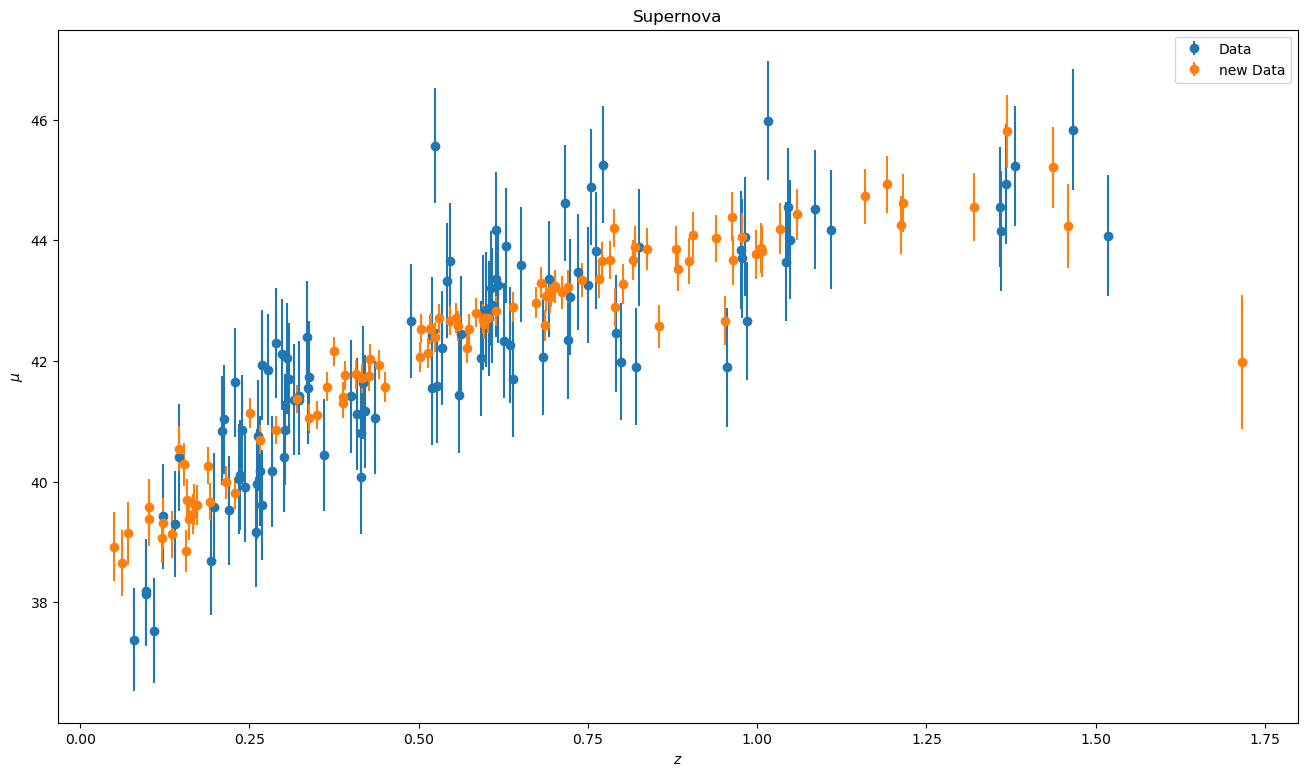

In [73]:
# Plot the old and the new data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Supernova')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')

ax.errorbar(z_sample, mu_sample, yerr=dmu, linestyle='', marker='o', label='Data')
ax.errorbar(np.squeeze(new_z_sample), np.squeeze(new_mu_sample_gpr), yerr=new_mu_sample_err_gpr,
            linestyle='', marker='o', label='new Data')

ax.legend()

plt.show()

#### $\Lambda\text{CDM}$ fit with $\Omega_m = 1$

##### Distribution of $H_0$

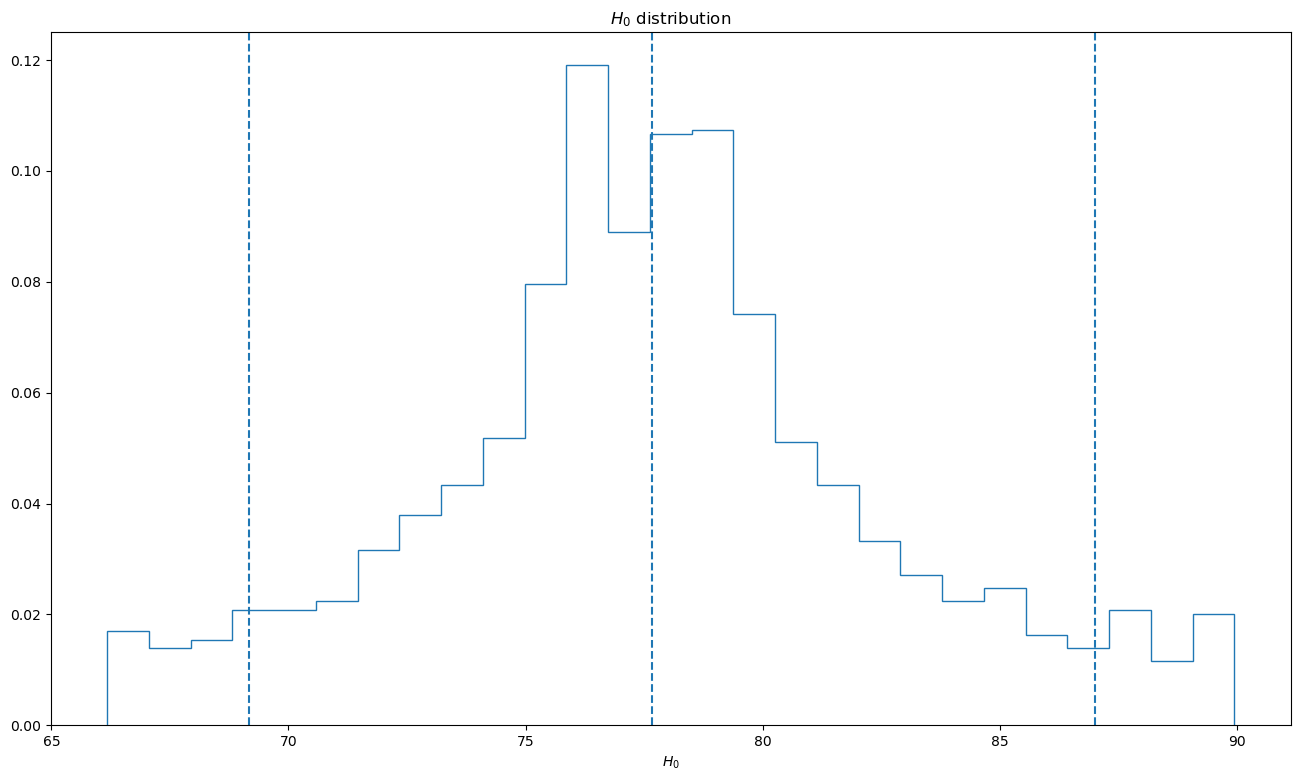

In [150]:
# Define the index to cut the sampling
start_index = 100

# Get the sampled H_0s and plot them along with some quantiles
H_0_sample = np.swapaxes(sresults_M['samples'], 0, 1)[par_indexes['H_0']][start_index:]
H_0_quantiles = np.quantile(H_0_sample, [0.05, 0.5, 0.95])

fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title(r'$H_0$ distribution')
ax.set_xlabel(r'$H_0$')

# Data
ax.hist(H_0_sample, bins='auto', density=True, histtype='step')

# Quantiles
for i in range(len(H_0_quantiles)):
    ax.axvline(H_0_quantiles[i], linestyle='--')

plt.show()

In [151]:
# Search for the best bandwidth for the kernel for the H_0 distribution
bw_grid = GridSearchCV(KernelDensity(), dict(bandwidth = np.linspace(1, 10, 100)), cv=5)

bw_grid.fit(H_0_sample[:, np.newaxis])

GridSearchCV(cv=5, estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 1.        ,  1.09090909,  1.18181818,  1.27272727,  1.36363636,
        1.45454545,  1.54545455,  1.63636364,  1.72727273,  1.81818182,
        1.90909091,  2.        ,  2.09090909,  2.18181818,  2.27272727,
        2.36363636,  2.45454545,  2.54545455,  2.63636364,  2.72727273,
        2.81818182,  2.90909091,  3.        ,  3.09090909,  3.18181818,
        3.27272727,  3.36363636,  3....
        6.90909091,  7.        ,  7.09090909,  7.18181818,  7.27272727,
        7.36363636,  7.45454545,  7.54545455,  7.63636364,  7.72727273,
        7.81818182,  7.90909091,  8.        ,  8.09090909,  8.18181818,
        8.27272727,  8.36363636,  8.45454545,  8.54545455,  8.63636364,
        8.72727273,  8.81818182,  8.90909091,  9.        ,  9.09090909,
        9.18181818,  9.27272727,  9.36363636,  9.45454545,  9.54545455,
        9.63636364,  9.72727273,  9.81818182,  9.90909091, 10.        ])})

In [152]:
bw_grid.best_params_['bandwidth']

4.636363636363637

In [153]:
# Initialize and fit KDEs with the optimized bandwidth and with a manually selected one
# Optimized
opt_H_0_kde = KernelDensity(bandwidth=bw_grid.best_params_['bandwidth'])

# Manually selected
my_bw = 1.5
my_H_0_kde = KernelDensity(bandwidth=my_bw)

# Fit both
my_H_0_kde.fit(H_0_sample[:, np.newaxis])
opt_H_0_kde.fit(H_0_sample[:, np.newaxis])

KernelDensity(bandwidth=4.636363636363637)

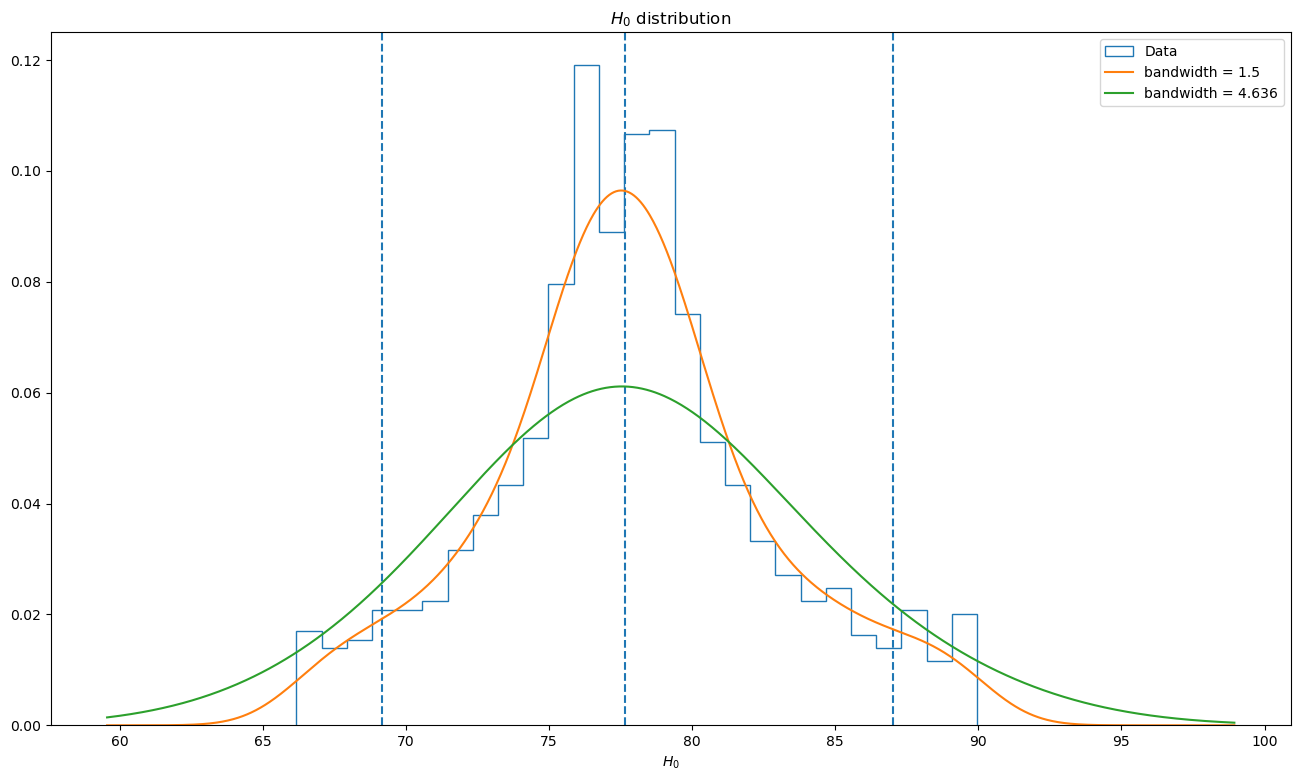

In [154]:
# Plot the H_0 distribution with its KDEs
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title(r'$H_0$ distribution')
ax.set_xlabel(r'$H_0$')

# Data
ax.hist(H_0_sample, bins='auto', density=True, histtype='step', label='Data')

# Quantiles
for i in range(len(H_0_quantiles)):
    ax.axvline(H_0_quantiles[i], linestyle='--')

# KDEs
H_0_grid = np.linspace(0.9 * np.min(H_0_sample), 1.1 * np.max(H_0_sample), n_grid_points)

ax.plot(H_0_grid, np.exp(my_H_0_kde.score_samples(H_0_grid[:, np.newaxis])),
        label='bandwidth = {0}'.format(np.format_float_positional(my_bw, 3)))
ax.plot(H_0_grid, np.exp(opt_H_0_kde.score_samples(H_0_grid[:, np.newaxis])),
        label='bandwidth = {0}'.format(np.format_float_positional(bw_grid.best_params_['bandwidth'], 3)))

ax.legend()

plt.show()

I choose my bandwith to sample values of $H_0$.

I sample from the KDE and I discard values out of the bounds defined by the 0.05 and the 0.95 quantiles.

In [161]:
# Sample values of H_0 to be used to generate new mu data points from the fitted model
# Generate some H_0 for every new sampled z

n_H_0_samples = 100

new_H_0_sample = [my_H_0_kde.sample(n_H_0_samples, random_state=int(time.time()))
                  for i in range(N)]

# # Costrain the samples to be between the 0.05 and 0.95 quantiles: same tecnique as for z
# for i in range(N):
#     sample_size = 0
#     # sample() already provides the correct shape for the scikit-learn interface
#     # I keep the correct shape by using properly the 'axis' parameter in numpy functions
#     while sample_size < n_H_0_samples:
#         # Delete out of bounds H_0
#         new_H_0_sample[i] = np.delete(new_H_0_sample[i],
#                                       np.where((new_H_0_sample[i] < H_0_quantiles[0]) |
#                                                (new_H_0_sample[i] > H_0_quantiles[2]))[0],
#                                                axis=0)

#         # Update the number of sampled points
#         sample_size = len(new_H_0_sample[i])

#         # Generate the missing number of points
#         new_H_0_sample[i] = np.append(new_H_0_sample[i],
#                                       my_H_0_kde.sample(n_H_0_samples - sample_size,
#                                                         random_state=int(time.time())), axis=0)

new_H_0_sample = np.array(new_H_0_sample)

In [162]:
# For every z select 1 random H_0 and
# Compute the standard deviation of the sampled H_0
temp_new_H_0 = np.zeros(len(new_H_0_sample))
new_H_0_sample_err = np.zeros(len(new_H_0_sample))
for i in range(len(new_H_0_sample)):
    temp_new_H_0[i] = new_H_0_sample[i][random.randint(0, n_H_0_samples)][0]
    new_H_0_sample_err[i] = np.std(new_H_0_sample[i])

# Reshape when assigning just for consistency
new_H_0_sample = np.reshape(temp_new_H_0, (len(temp_new_H_0), 1))

del temp_new_H_0

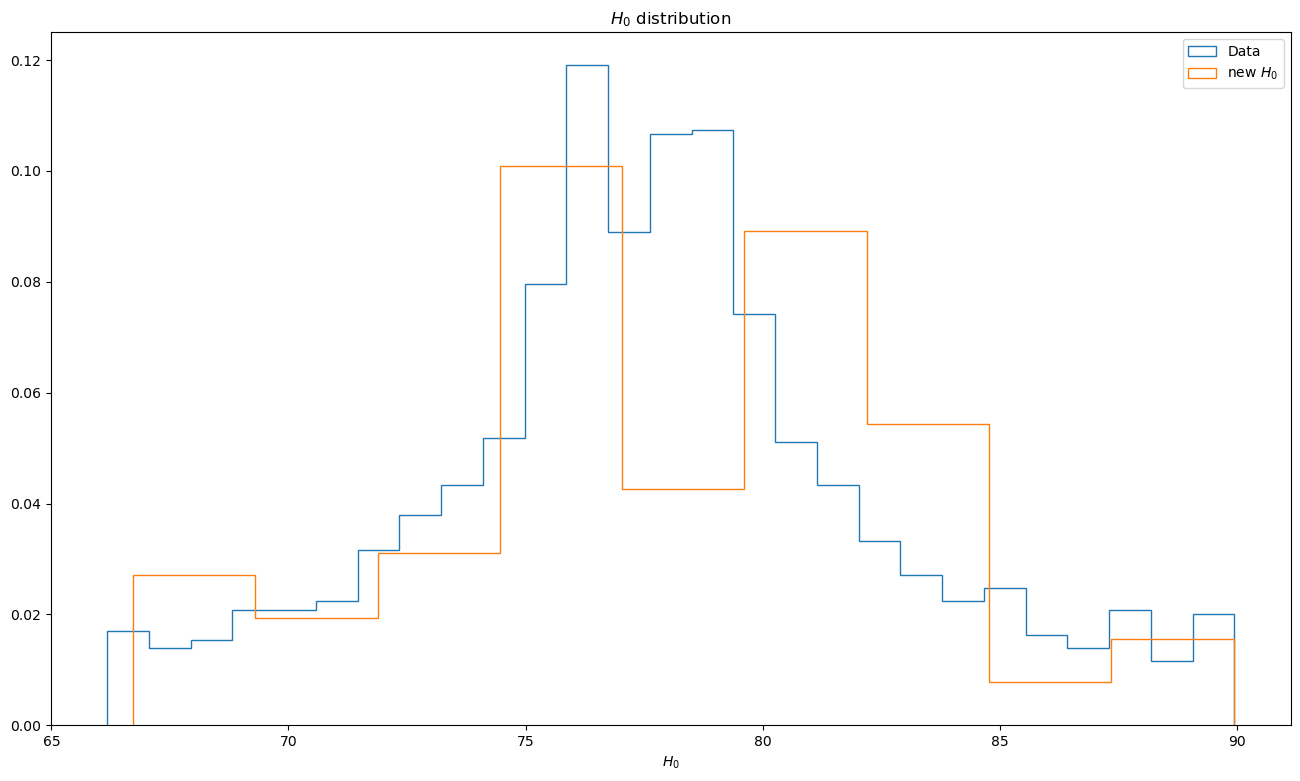

In [163]:
# Plot the obtained H_0 distribution along with the original one
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title(r'$H_0$ distribution')
ax.set_xlabel(r'$H_0$')

ax.hist(H_0_sample, bins='auto', density=True, histtype='step', label='Data')
ax.hist(new_H_0_sample, bins='auto', density=True, histtype='step', label='new $H_0$')

ax.legend()

plt.show()

##### We can now generate values of $\mu$ using the previously sampled $z$ and the new values of $H_0$.

In [164]:
new_mu_sample_fit = np.array([mu(new_z_sample[i], new_H_0_sample[i], Omega_m=1) for i in range(N)])

Neglecting the error on the integral, the error on $\mu$ due to $H_0$ should be:

\begin{align*}
\sigma_\mu = \frac{5}{\ln(10)} \frac{\sigma_{H_0}}{H_0}
\end{align*}

In [165]:
new_mu_sample_err_fit = (5 / np.log(10)) * (new_H_0_sample_err / np.squeeze(new_H_0_sample))

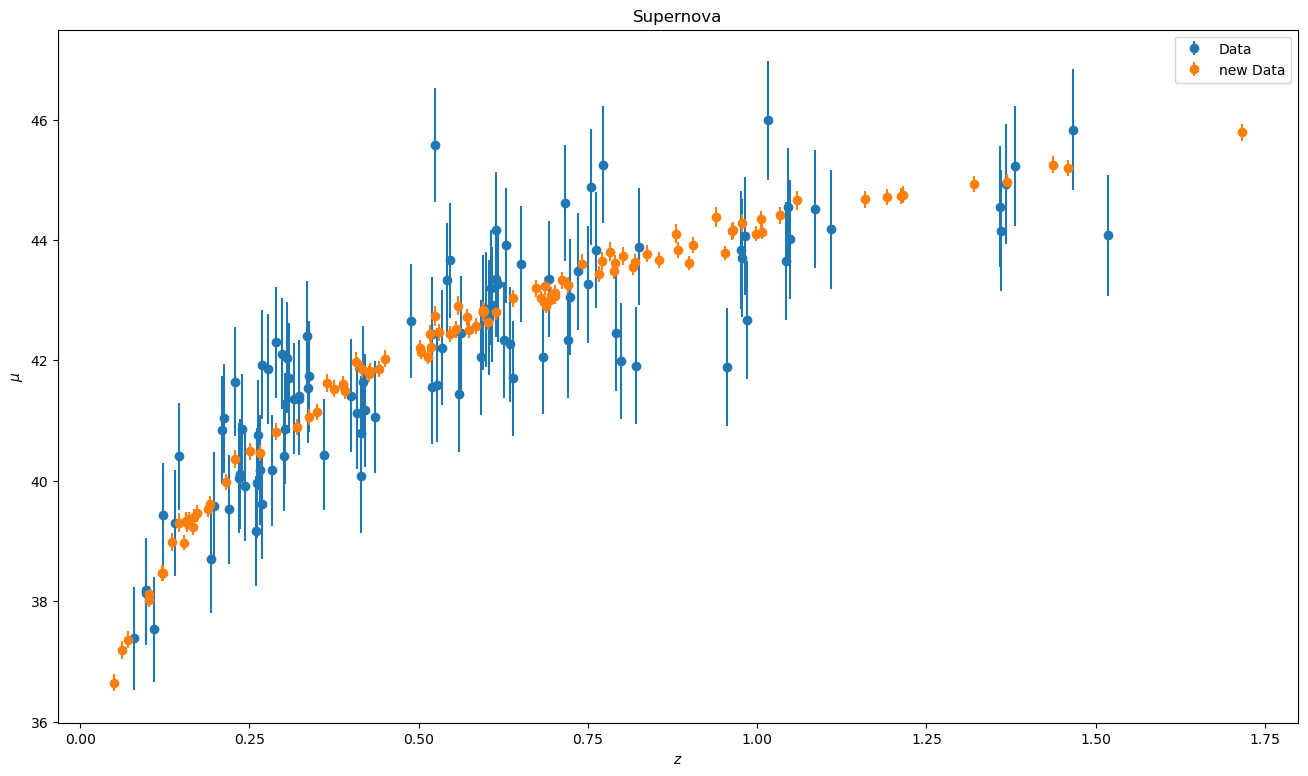

In [166]:
# Plot the old and the new data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Supernova')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')

ax.errorbar(z_sample, mu_sample, yerr=dmu, linestyle='', marker='o', label='Data')
ax.errorbar(np.squeeze(new_z_sample), np.squeeze(new_mu_sample_fit), yerr=new_mu_sample_err_fit,
            linestyle='', marker='o', label='new Data')

ax.legend()

plt.show()